## Graph Neural Networks with Keras and Cora

Author: [Savannah Thais](https://github.com/savvy379)

Adapted from the [Keras Tutorial](https://keras.io/examples/graph/gnn_citations/)


### Introduction

This notebook teaches the reader how to build a Graph Neural Network (GNN) with Keras. It is a modified version of the Keras [Tutorial](https://keras.io/examples/graph/gnn_citations/) on GNNs. This setup and example was selected to work well with the existing LPC-HATS ML Tutorial tech stack, however I note that [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)(PyG) is much more commonly used to construct and train GNNs and other Geometric Deep Learning models. This notebook introduces the theory and basics of building and training a GNN, but I encourage you to explore the PyG [tutorials](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) as well.  

A graph $G$ is a mathematical object consisting of a set of nodes (vertices) $N$ and edges $E$, $G=(N,E)$. Graphs can easily represent a wide range of structured data including atoms in molecules, users in a social network, cities and roads in a transportation system, players in team sports, objects interacting in a dynamical physical system, detector events , and more. The nodes and edges of the graph can have associated features as defined by the developer; these can include geometric information (ie particle hit locations in a detector) and non-geometric information (ie particle momenta). Graphs can be directed or undirected. A major advantage of GNNs is that they can handle input data of varying sizes: each graph processed by the network can have a different number of nodes and edges, making them well suited for a range of HEP applications.

<div>
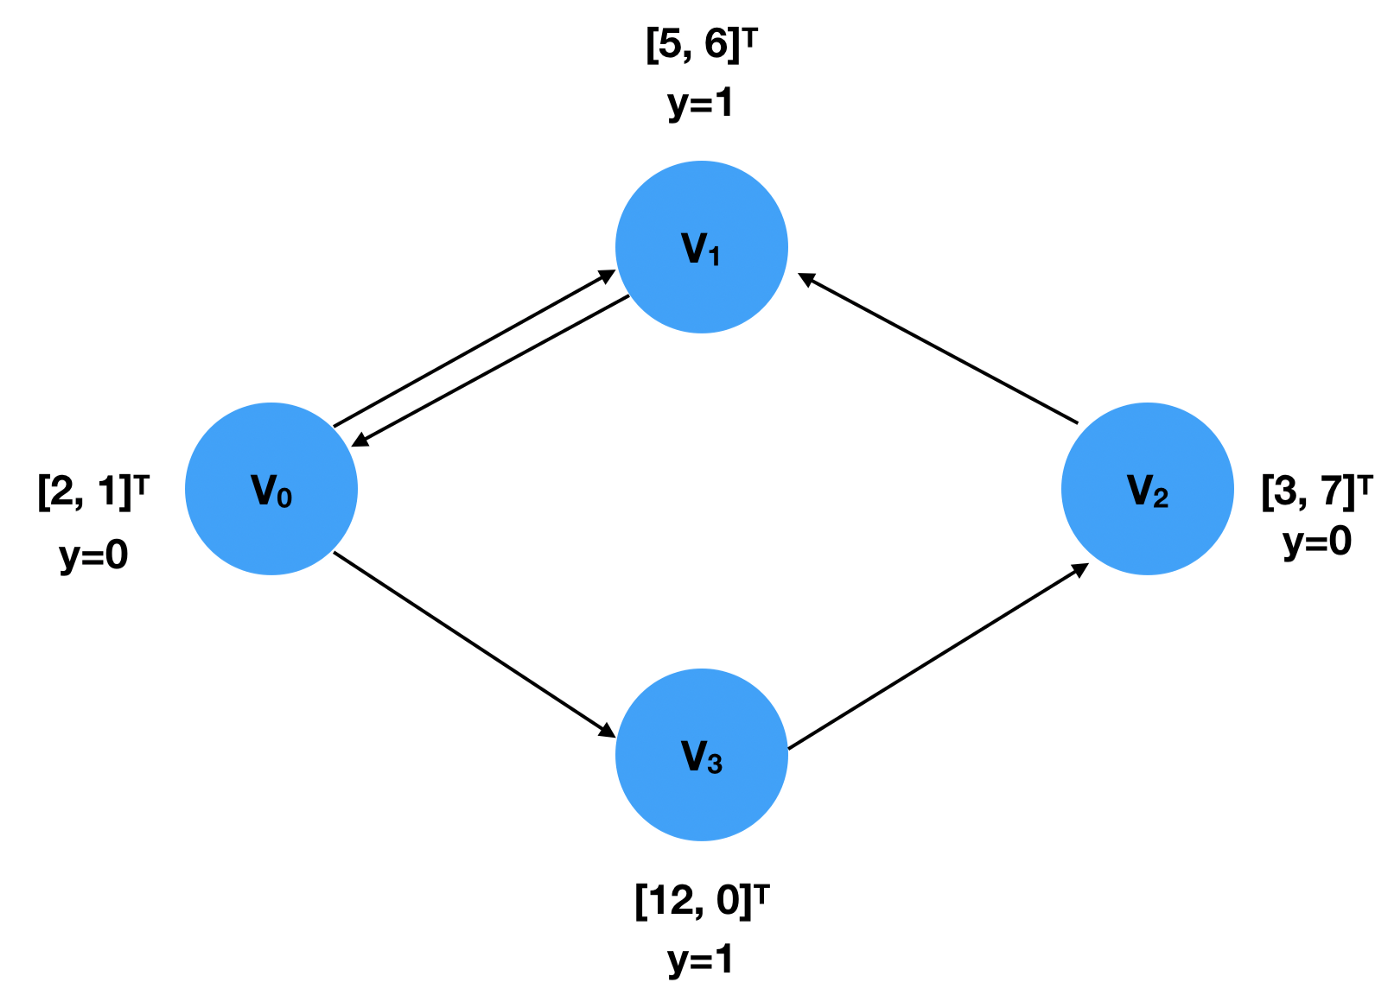
    </div>


In general, GNNs work by leveraging local information across the graph structure to intelligently re-embed the edges and nodes. A commonly used class of GNNs (and the focus of this tutorial) is the Graph Convolutional Network (GCN). GCNs use the same convolution operations as in a normal CNN, but apply the convolutions to node neighborhoods rather than a fixed data tensor (like an image matrix). These are considered a type of "Message Passing Network" when are 'message' is constructed by combining and transforming information from neighboring nodes and that message is 'passed' to a target node and used to update its features. In this way the entire graph can be transformed such that each node is updated to include additional useful information. The convolved graph is typically then processed by an additional linear layer that uses node and or edge features to do classification or regression on individual graph elements, graph substructures, or the graph as a whole. (Note: the same message passing structure can be applied to edges instead of nodes to update edge features as well). 

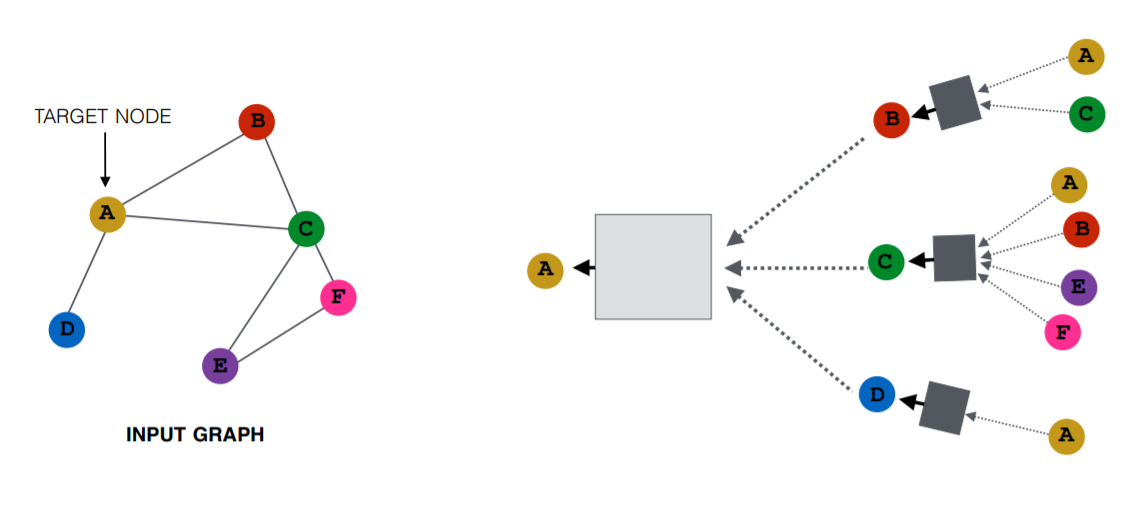

In mathematical terms, a single graph convolution layer can be described as: 

<div>
<img src=attachment:image.png width=600>
    </div>

Here, $h_v^0$ is the initial embedding of node $v$ (ie the original node features). To update the embedding of node $v$, $h_v^k$, the 'message' is constructed by applying a function $f$ to a the average over the current embedding of all the neighboring nodes (nodes connected to $v$ by a graph edge: $N(v)$) $\sum_{u \in N(v)}\frac{h_u^{k-1}}{deg(v)}$ and, optionally, the current embedding of the target node: $h_v^{k-1}$ then passed through a non-linear activation function and used to update the target node. In practice the functions $f$ is approximated by a matrix (convolution) $Wk$ with the added non-linearity of the activation function.   
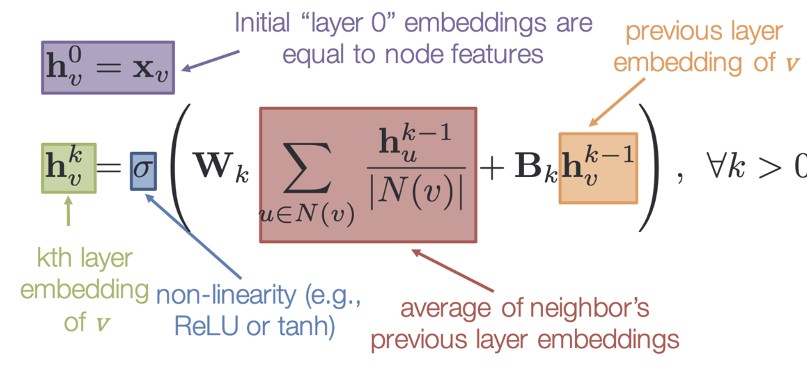

This entire process is visualized in the below diagram, taken from the excellent paper [A Practical Guide to Graph Neural Networks](https://arxiv.org/abs/2010.05234)

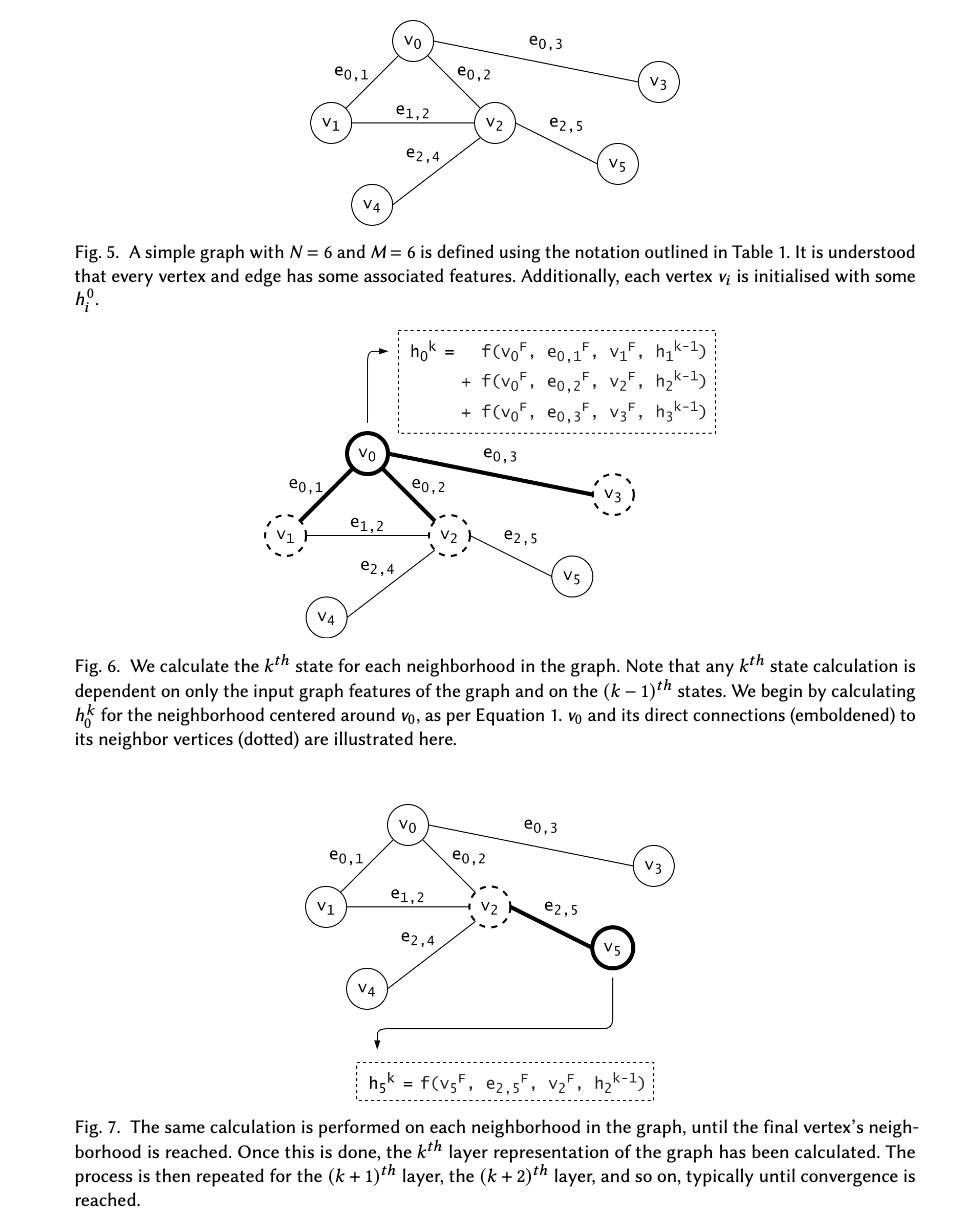

### Coding!

#### The Dataset

In this tutorial we will use the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA) to predict the subject of a research paper given its words and citation network. The cora dataset consists of 2,708 scientific papers with a unique id classified into one of 7 classes. The citation network consists of 5,429 links. Each paper has an associated binary word vector of size 1,433 indiating the presence of correpsonding word fromt he pre-defined dictionary. 

The dataset cnotains two tab-separateve files: `cora.cites` and `cora.content`. The cites file includes all pairs of citation records formulated as two columns: `cited_paper_id` (target) and `citing_paper_id` (source). The content file includes the paper content recors with 1,435 columns: `paper_id`, `subject` (training target), and 1,433 binary features corresponding to the binary word vector. 

Let's download the dataset

In [1]:
#setup 
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [2]:
#download the data
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

172032/168052 [==============================] - 0s 0us/step


Load the cites data into a dataframe and get the shape. We expect it to be 5429x2, representing 5429 linked paper pairs.


In [3]:
#load the cites data into a dataframe and get the shape (expect it to be 5429x2, representing 5429 linked paper pairs)
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


We can also take a look at the beginning of the dataset

In [4]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


The first few lines are listing the papers that reference paper ID 35.

Now we'll load the papers data and get the shape and take a look at the first few entries. We expect this df to be 2708x1435: 2708 unique papers and their associated topic and word binaries. 

In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [6]:
print(papers.sample(5).T)

                 1412           178   ...             2084                2220
paper_id       120039        1153866  ...            51934               22229
term_0              0              0  ...                0                   0
term_1              0              0  ...                0                   0
term_2              0              0  ...                0                   0
term_3              0              0  ...                0                   0
...               ...            ...  ...              ...                 ...
term_1429           0              0  ...                0                   0
term_1430           0              0  ...                0                   0
term_1431           0              0  ...                0                   0
term_1432           0              0  ...                0                   0
subject    Case_Based  Rule_Learning  ...  Neural_Networks  Genetic_Algorithms

[1435 rows x 5 columns]


We can also look at the count of papers in each subject:

In [7]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


We'll do a bit of preprocessing to convert the paper ids and subjects into zero-based indices. The papers will be indexed starting from 0 and the paper subjects will be represented by a value between 0 and 7, correpsonding to the subject classes.

In [8]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

We can use the `networkx` package to visualize a subset of the papers in the citation graph format. Each node will represent an idividual paper, nodes will be connected by an edge if one paper cites the other, and the color of each node will represent subject area. 

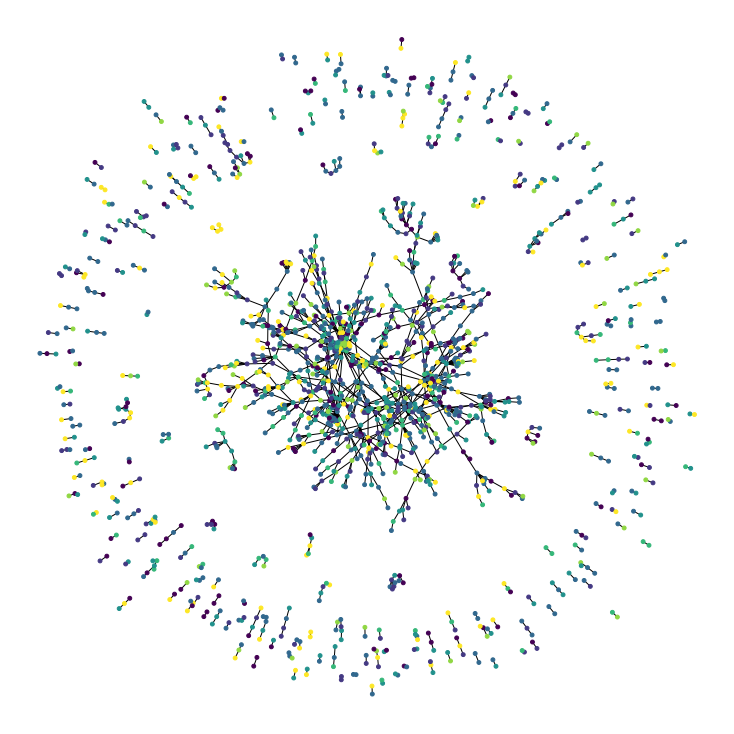

In [9]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

Finally, we'll split the data into train and test sets

In [10]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1361, 1435)
Test data shape: (1347, 1435)


#### Experiment setup
We'll define a few helper functions to use as we develop and train our GNN. Let's start with setting some hyperparameters: 

In [11]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

Define a function to compile and train a selected model using the training data:

In [12]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

And one to display the training loss and accuracy curves:

In [13]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

And one to construct a simple Feed-Forward Network (FFN)

In [14]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu))

    return keras.Sequential(fnn_layers, name=name)

#### Converting data to a graph

In order to use the Cora dataset with a GNN we need to transform it into the format expected by Keras. This is often one of the most challenging parts of building a GNN model as each library has slightly different expected data formats and different systems have varying memory constraints. Here we will demonstrate a simple approach for preparing and using graph data if your dataset contains only a signle graph that fits entirely in memory. 

In Keras, the graph data is represented by a `graph_info` tuple which consists of three elements:
1. `node_features`: This is a `[num_nodes, num_features]` Numpy array that includes the features of each node. In our case each node is a paper and the features are the word presence binary vectors.
2. `edges`: This is a `[2,num_edges]` Numpy arrary representing a sparce adjacency matrix of the links between the nodes. For each edge this array includes the node index of the source and target node. In our case, these are the citing paper and cited paper IDs.  
3. `edge_weights` (optional): This is a `[num_edges]` Numpy array that includes the edge weights which quantify the relationship between the nodes. In our exaple we don't use edge weights, but a possible example of a useful edge weight for this task could be the impact factor of the journal where the citing paper is published. 

We'll also define an array `y` containing the subject labels for each paper ID.

In [15]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)
# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
y_train = train_data["subject"]
print(y_train)
y_test = test_data["subject"]

1925    1
2345    6
2607    0
2271    1
1123    0
       ..
701     2
1699    0
1491    6
666     2
906     2
Name: subject, Length: 1361, dtype: int64


In [16]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


#### Build the model!

We'll start by defining a graph convolution layer. It performs the following steps: 
1. **Prepare**: The input node representations are processed using a Feed-Forward Network (FFN) to produce a message. You can simplify the processing by only applying linear transformation to the representations.
2. **Aggregate**: The messages of the neighbours of each node are aggregated with respect to the edge_weights using a permutation invariant pooling operation, such as sum, mean, or max, to prepare a single aggregated message for each node. See, for example, tf.math.unsorted_segment_sum APIs used to aggregate neighbour messages.
3. **Update**: The node_repesentations and aggregated_messages—both of shape `[num_nodes, representation_dim]` — are combined and processed to produce the new state of the node representations (node embeddings). If combination_type is gru, the node_repesentations and aggregated_messages are stacked to create a sequence, then processed by a GRU layer. Otherwise, the node_repesentations and aggregated_messages are added or concatenated, then processed using a FFN.

In [17]:
# Graph convolutional layer

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


Now we can use this GCN layer in a full GNN architecture for node classification. We'll define our network as follows: 

1. Apply preprocessing using FFN to the node features to generate initial node representations. (This step is optional as you can just use the original node features as the initial representation).
2. Apply one or more graph convolutional layer, with skip connections, to the node representation to produce node embeddings.
3. Apply post-processing using FFN to the node embeddings to generat the final node embeddings.
4. Feed the node embeddings in a Softmax layer to predict the node class.

Each graph convolutional layer added captures information from a further level of neighbours. However, adding many graph convolutional layer can cause oversmoothing, where the model produces similar embeddings for all the nodes. The number of message passing iterations can be considered a tuneable hyperparameter. 

Note that the graph_info passed to the constructor of the Keras model, and used as a property of the Keras model object, rather than input data for training or prediction. The model will accept a batch of node_indices, which are used to lookup the node features and neighbours from the graph_info.

In [18]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)


Let's try calling our model! 

In [19]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 1.8012416e-02  4.9491808e-02  9.8944223e-03  1.1198113e-01
   7.6205209e-02 -1.4386458e-04  2.3376463e-02]
 [ 7.1263225e-03  7.7160872e-03  4.3582007e-02  9.7338274e-02
   1.0342301e-01  4.5803756e-02  1.4947498e-01]
 [-1.0139931e-01 -2.6689304e-02 -1.2470722e-02  6.9937572e-02
   1.9118384e-03 -4.9269162e-02  1.7952232e-01]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (2708, 32)                52804     
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (2708, 32)                2368    

#### Train the model
We're ready to train our GNN! We'll use standard supervised cross-entropy loss to train the model as defined in our helper function above. 

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
5/5 [==============================] - 8s 247ms/step - loss: 2.2244 - acc: 0.1652 - val_loss: 1.9001 - val_acc: 0.2732
Epoch 2/300
5/5 [==============================] - 1s 140ms/step - loss: 1.9735 - acc: 0.2552 - val_loss: 1.8958 - val_acc: 0.2585
Epoch 3/300
5/5 [==============================] - 1s 145ms/step - loss: 1.9356 - acc: 0.2517 - val_loss: 1.9035 - val_acc: 0.1756
Epoch 4/300
5/5 [==============================] - 1s 145ms/step - loss: 1.8796 - acc: 0.2448 - val_loss: 1.9045 - val_acc: 0.2000
Epoch 5/300
5/5 [==============================] - 1s 140ms/step - loss: 1.8755 - acc: 0.2561 - val_loss: 1.8984 - val_acc: 0.2732
Epoch 6/300
5/5 [==============================] - 1s 144ms/step - loss: 1.8457 - acc: 0.2751 - val_loss: 1.8910 - val_acc: 0.2878
Epoch 7/300
5/5 [==============================] - 1s 145ms/step - loss: 1.8

Let's plot the learning curves

In [ ]:
display_learning_curves(history)

And finally we can evaluate the GNN on the test data split! 

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")